# Spring 2022 6.484 Computational Sensorimotor Learning Assignment 6

In this assignment, we will implement model-based control algorithms for Cartpole swing-up.

You will need to **answer the bolded questions** and **fill in the missing code snippets** (marked by **TODO**).

There are **210** total points to be had in this PSET, plus 10 bonus points for filling out the survey.  `ctrl-f` for "pts" to ensure you don't miss questions.

**_Please fill in your name below:_**

**Name**: Luis Costa Laveron

In [1]:
!sudo apt-get update > /dev/null 2>&1
!apt-get install -y ffmpeg > /dev/null 2>&1
!pip install gym > /dev/null 2>&1


In [62]:
%matplotlib inline

import gym
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation
from matplotlib.axes import Axes
from matplotlib import rc
import random
from torch import nn
from gym.envs.registration import registry, register

rc('animation', html='jshtml')

# Environment

For this assignment, our task will be to swing-up and balance Cartpole (note that this is different from the standard cartpole gym env, where the stick starts in the upwards orientation).  As a backbone to our gym environment, we provide the class `CartpoleDynamics` which implements the ground truth cartpole dynamics in Pytorch (for speed).

Note that in the controls literature, $q$ is commnly referred to as the state and $u$ as the control or input or action.

Note that our observation space in this environment is of size 4 and the action space is of size 1.

*Cartpole plotting and animation code inspired by [Shunichi09/PythonLinearNonLinearControl](https://github.com/Shunichi09/PythonLinearNonlinearControl)* 

In [3]:
class CartpoleDynamics:
    def __init__(self,
                 timestep=0.02,
                 m_p=0.5,
                 m_c=0.5,
                 l=0.6,
                 g=-9.81,
                 u_range=15):
        
        self.m_p  = m_p
        self.m_c  = m_c
        self.l    = l
        self.g    = -g
        self.dt   = timestep
        
        self.u_range = u_range

        self.u_lb = torch.tensor([-1]).float()
        self.u_ub = torch.tensor([1]).float()
        self.q_shape = 4
        self.u_shape = 1
    
    def _qdotdot(self, q, u):
        x, theta, xdot, thetadot = q.T

        if len(u.shape) == 2:
            u = torch.flatten(u)
        
        x_dotdot = (
            u + self.m_p * torch.sin(theta) * (
                self.l * torch.pow(thetadot,2) + self.g * torch.cos(theta)
            )
        ) / (self.m_c + self.m_p * torch.sin(theta)**2)
        
        theta_dotdot = (
            -u*torch.cos(theta) -
            self.m_p * self.l * torch.pow(thetadot,2) * torch.cos(theta) * torch.sin(theta) - 
            (self.m_c + self.m_p) * self.g * torch.sin(theta)
        ) / (self.l * (self.m_c + self.m_p * torch.sin(theta)**2))
                
        return torch.stack((x_dotdot, theta_dotdot), dim=-1)
    
    def _euler_int(self, q, qdotdot):
        qdot_new = q[...,2:] + qdotdot * self.dt
        q_new = q[...,:2] + self.dt * qdot_new

        return torch.cat((q_new, qdot_new), dim=-1)
    
    def step(self, q, u):

        # Check for numpy array
        if isinstance(q, np.ndarray):
            q = torch.from_numpy(q)
        if isinstance(u, np.ndarray):
            u = torch.from_numpy(u)

        scaled_u = u * float(self.u_range)    
            
        # Check for shape issues
        if len(q.shape) == 2:
            q_dotdot = self._qdotdot(q, scaled_u)
        elif len(q.shape) == 1:
            q_dotdot = self._qdotdot(q.reshape(1,-1), scaled_u)
        else:
            raise RuntimeError('Invalid q shape')
            
        new_q = self._euler_int(q, q_dotdot)

        if len(q.shape) == 1:
            new_q = new_q[0]
            
        return new_q
    
    # given q [bs, q_shape] and u [bs, t, u_shape] run the trajectories
    def run_batch_of_trajectories(self, q, u):
        qs = [q]
        
        for t in range(u.shape[1]):
            qs.append(self.step(qs[-1], u[:,t]))
                
        return torch.stack(qs, dim=1)
    
    # given q [bs, t, q_shape] and u [bs, t, u_shape] calculate the rewards
    def reward(self, q, u):
        if isinstance(q, np.ndarray):
            q = torch.from_numpy(q)
        if isinstance(u, np.ndarray):
            u = torch.from_numpy(u)

        angle_term = 0.5*(1-torch.cos(q[...,1]))
        pos_term = -0.5*torch.pow(q[...,0],2)
        ctrl_cost = -0.001*(u**2).sum(dim=-1)
                        
        return angle_term + pos_term + ctrl_cost

class CartpoleGym(gym.Env):
    def __init__(self, timestep_limit=200):
        self.dynamics = CartpoleDynamics()
        
        self.timestep_limit = timestep_limit
        self.reset()

    def reset(self):
        self.q_sim = np.zeros(4)
        self.timesteps = 0

        self.traj = [self.get_observation()]

        return self.traj[-1]

    def get_observation(self):
        return self.q_sim
            
    def step(self, action):
        action = np.clip(action, self.action_space.low, self.action_space.high)[0]
        
        new_q = self.dynamics.step(
            self.q_sim, action
        )
        
        if not isinstance(action, torch.Tensor):
            action = torch.tensor(action)
        
        reward = self.dynamics.reward(
            new_q, action
        ).numpy()
        
        self.q_sim = new_q.numpy()
        done = self.is_done()
        
        self.timesteps += 1

        self.traj.append(self.q_sim)
        
        return self.q_sim, reward, done, {}
    
    def is_done(self):
        # Kill trial when too much time has passed
        if self.timesteps >= self.timestep_limit:
            return True
                
        return False
    
    def plot_func(self, to_plot, i=None):
        def _square(center_x, center_y, shape, angle):
            trans_points = np.array([
                [shape[0], shape[1]],
                [-shape[0], shape[1]],
                [-shape[0], -shape[1]],
                [shape[0], -shape[1]],
                [shape[0], shape[1]]
            ]) @ np.array([
                [np.cos(angle), np.sin(angle)],
                [-np.sin(angle), np.cos(angle)]
            ]) + np.array([center_x, center_y])

            return trans_points[:, 0], trans_points[:, 1]
        
        if isinstance(to_plot, Axes):
            imgs = dict(
                cart=to_plot.plot([], [], c="k")[0],
                pole=to_plot.plot([], [], c="k", linewidth=5)[0],
                center=to_plot.plot([], [], marker="o", c="k",
                                          markersize=10)[0]
            )

            x_width = max(1,max(np.abs(t[0]) for t in self.traj) * 1.3)

            # centerline
            to_plot.plot(np.linspace(-x_width, x_width, num=50), np.zeros(50),
                         c="k", linestyle="dashed")

            # set axis
            to_plot.set_xlim([-x_width, x_width])
            to_plot.set_ylim([-self.dynamics.l*1.2, self.dynamics.l*1.2])

            return imgs

        curr_x = self.traj[i]

        cart_size = (0.15, 0.1)

        cart_x, cart_y = _square(curr_x[0], 0.,
                                cart_size, 0.)

        pole_x = np.array([curr_x[0], curr_x[0] + self.dynamics.l
                           * np.cos(curr_x[1]-np.pi/2)])
        pole_y = np.array([0., self.dynamics.l
                           * np.sin(curr_x[1]-np.pi/2)])

        to_plot["cart"].set_data(cart_x, cart_y)
        to_plot["pole"].set_data(pole_x, pole_y)
        to_plot["center"].set_data(self.traj[i][0], 0.)
    
    def render(self, mode="human"):
        self.anim_fig = plt.figure()

        self.axis = self.anim_fig.add_subplot(111)
        self.axis.set_aspect('equal', adjustable='box')

        imgs = self.plot_func(self.axis)
        _update_img = lambda i: self.plot_func(imgs, i)

        Writer = animation.writers['ffmpeg']
        writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)

        ani = FuncAnimation(
            self.anim_fig, _update_img, interval=self.dynamics.dt*1000, 
            frames=len(self.traj)-1
        )

        plt.close()

        return ani
        
    @property
    def action_space(self):
        return gym.spaces.Box(low=self.dynamics.u_lb.numpy(), high=self.dynamics.u_ub.numpy())

    @property
    def observation_space(self):
        return gym.spaces.Box(
            low= np.array([-np.inf, -np.inf, -np.inf, -np.inf]),
            high=np.array([np.inf,   np.inf,  np.inf,  np.inf])
        )

env_name = 'CartpoleSwingUp-v0'
if env_name in registry.env_specs:
    del registry.env_specs[env_name]
register(
    id=env_name,
    entry_point=f'{__name__}:CartpoleGym',
)


As a demonstration, let's try to plot a random policy on this environment.

In [4]:
env = gym.make('CartpoleSwingUp-v0')

q = env.reset()
done = False
while not done:
    q, r, done, _ = env.step(env.action_space.sample())

env.render()

# Model Predictive Control

Model-based RL works by decomposing policy into two components:

1. A model of the MDP, learned from data
2. A planner, that given the learned MDP, can produce optimal action estimates.

Let's begin by implementing step 2: the planner.  As we're in the world of continuous control, we will implement a *Model Predictive Controller*: at every timestep we will solve for an optimal trajectory, than take the first action.

One simple MPC method is Cross Entropy Maximization (CEM), as used in [PETS](https://arxiv.org/pdf/1805.12114.pdf).  The idea here is to continuously optimize a rolling Gaussian input trajectory segment.  At each timestep, advance the trajectory segment by one, generate a population of new input segments by sampling from the last input segment, and evaluate each trajectory.  Then, select the top `es_elites` trajectories from that population with the highest reward, fit the input trajectory segment to their distribution, and repeat for `es_generations` generations.  If the input trajectory variance reaches below a threshold `es_epsilon`, exit early.

Implement a CEM MPC controller, using the given parameters defined in `__init__` and both `self.model.run_batch_of_trajectories` and `self.model.reward` to evaluate trajectories.

Note that `run_batch_of_trajectories` takes as input a batch of initial states $(bs, u\_size)$ and a trajectory of actions $(bs, t, q\_size)$ and returns a batch of trajectories $(bs, t + 1)$. Each trajectory in the batch is generated by sequentially applying each action in the trajectory to updated states (starting with the initial inputted state). `reward` takes a sequence of states $(bs, t, q\_size)$ and a sequence of actions $(bs, t, u\_size)$ applied to get to that state and returns a reward $(bs, t)$, consisting of a term based off the position, angle, and action magnitude. 

**(50 pts)**

In [45]:
class MPC:
    def __init__(self,
        model,
        horizon        = 25,
        es_epsilon     = 0.001,
        es_alpha       = 0.1,
        es_generations = 5,
        es_popsize     = 200,
        es_elites      = 40
    ):
                
        self.model          = model
        
        self.horizon        = horizon        # planning horizon
        self.es_epsilon     = es_epsilon     # variance threshold
        self.es_alpha       = es_alpha       # new distribution rolling average coefficient
        self.es_generations = es_generations # num generations for ES optimizer
        self.es_popsize     = es_popsize     # popsize for ES optimizer
        self.es_elites      = es_elites      # num of elites from which to resample

        self.reset()

    def reset(self):
        # Initialize action trajectory distribution
        self.sol_mean = ((self.model.u_lb + self.model.u_ub) / 2).expand(self.horizon,-1)
        self.sol_var = ((self.model.u_ub - self.model.u_lb) / 16).expand(self.horizon,-1)
        
        self.timestep = 0
    
    def action(self, q):
        # Remove last taken action and add 0 to end of buffer
        self.sol_mean = torch.cat([
            self.sol_mean[1:],
            torch.zeros(self.model.u_shape).reshape(1,-1)
        ])        
                
        # Generate standard diagonal normal distribution from which we sample trajectory noise        
        u_dist = torch.distributions.normal.Normal(
            loc=torch.zeros_like(self.sol_mean), 
            scale=torch.ones_like(self.sol_var)
        )
        
        var = self.sol_var
        for n in range(self.es_generations):            
            # Terminate if variance drops below threshold
            if torch.max(var) < self.es_epsilon:
                print(f'var below threshold! exiting {n}')
                break

            lb_dist = self.sol_mean - self.model.u_lb
            ub_dist = self.model.u_ub - self.sol_mean
            constrained_var = torch.min(
                torch.min((lb_dist / 2)**2, (ub_dist / 2)**2), var
            )
            
            ### TODO: perform one ES trajectory optimization step, by
            ### 1. sampling a trajectory
            ### 2. evaluating the fitness of that trajectory on the model
            ### 3. re-fitting self.sol_mean for the top N elites of the model
            ### (50 pts)
            
            #1. and 2. 
            action_dist = torch.distributions.normal.Normal(
              loc=self.sol_mean, 
              scale=constrained_var
            )
            
            B = self.es_popsize
            initial_states = torch.tensor(q).repeat(B,1) 
            actions = torch.zeros((B,self.horizon,self.model.u_shape))

            for b in range(B):
                action = action_dist.sample()
                actions[b,:,:] = action

            trajs = self.model.run_batch_of_trajectories(initial_states,actions)
            rewards = self.model.reward(trajs[:,1:,:],actions)
            avg_rewards = rewards.mean(axis=1)
            
            #3. 
            _, idx = avg_rewards.sort(descending=True)
            mean_elites = actions[idx[:self.es_elites],:,:].mean(axis=0)
            self.sol_mean = mean_elites 

            del initial_states; del actions; del trajs; del rewards; del avg_rewards; del idx; del mean_elites;
            ### ENDTODO

            n += 1
        
        self.timestep += 1
        return self.sol_mean[0]

Now, let's evaluate your MPC controller on the ground truth cartpole dynamics `CartpoleDynamics`.  The cartpole should swing up on the first (and only) epoch; there's no learning here, as the dynamics model is known.

In [47]:
mpc = MPC(CartpoleDynamics())
e = gym.make('CartpoleSwingUp-v0')

q, r, done = e.reset(), 0, False

while not done:
    q, reward, done, _ = e.step(mpc.action(q))
    r += reward
print('Got reward:', r)
e.render()

Got reward: 123.89246493712272


KeyboardInterrupt: ignored

In [36]:
#vary horizon
hvals = [5,15,25,50,100]
rewards = []
for h in hvals:
  mpc = MPC(CartpoleDynamics(), horizon = h)
  e = gym.make('CartpoleSwingUp-v0')

  q, r, done = e.reset(), 0, False
  steps = 0 
  while not done:
      q, reward, done, _ = e.step(mpc.action(q))
      r += reward
      steps += 1 
  rewards.append(r)
      
  print('Got reward:', r)

Got reward: 65.89339591459618
Got reward: 102.79260185489542
Got reward: 131.98092930006808
Got reward: 160.1339124988541
Got reward: 104.15910294295401


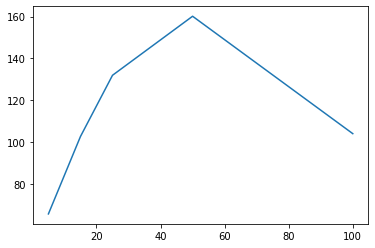

In [37]:
plt.plot(hvals, rewards)

In [38]:
#vary popsize
popvals = [50,100,200,400,800]
rewards_pop = []
for pop in popvals:
  mpc = MPC(CartpoleDynamics(), es_popsize= pop)
  e = gym.make('CartpoleSwingUp-v0')

  q, r, done = e.reset(), 0, False
  steps = 0 
  while not done:
      q, reward, done, _ = e.step(mpc.action(q))
      r += reward
      steps += 1 
  rewards_pop.append(r)
      
  print('Got reward:', r)

Got reward: 104.18254912239897
Got reward: 125.48155433208649
Got reward: 128.19461060831622
Got reward: 121.67452837609562
Got reward: 107.69662778323865


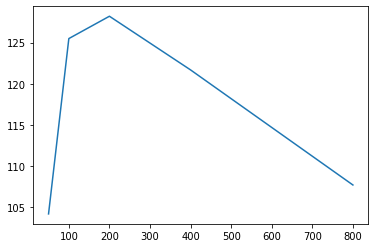

In [39]:
plt.plot(popvals, rewards_pop)

**Question**: Try varying the time horizon for MPC planning.  What behaviors do you see? (10 pts)

**Answer**:

**Question**: Try varying the number of random seeds for MPC (`es_popsize`).  What behaviors do you see? (10 pts)

**Answer**:

# Learned Dynamics Model

Now that we've debugged our MPC module, let's implement a learned model, so we no longer need the ground truth dynamics.  Our goal here is to learn some model $\hat f(q_t, u_t) = \hat q_{t+1}$, rather than implementing it analytically. 

Some hints:

- Consider normalizing values as necessary.
- For angles, consider replacing the angle in your feature space with `sin` and `cos` of the angle
- Consider learning the model $\hat f$ as $\hat f(q_t, u_t) = \hat g(q_t, u_t) + q_t$, rather than predicting new states from scratch (i.e., learn some residual instead)

**(50 points)**

In [106]:
def set_random_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
  
class LearnedCartpoleDynamics:
    def __init__(self, seed, u_range=15):
        set_random_seed(seed)
        self.u_range = u_range

        self.u_lb = torch.tensor([-u_range]).float()
        self.u_ub = torch.tensor([u_range]).float()
        self.u_shape = 1
        self.q_shape = 4 
        input_size = self.u_shape + self.q_shape + 2
        self.model = nn.Sequential(
            nn.Linear(input_size, 48), #used to be 6, with u_shape = 1 and no q_shape definition
            nn.ReLU(),
            nn.Linear(48, 48),
            nn.ReLU(),
            nn.Linear(48, 4),
            nn.Tanh()
        )

        self.optim = torch.optim.Adam(self.model.parameters())
        self.loss = nn.MSELoss()
        
    def step(self, q, u):
        ### TODO: implement forward dynamics call of f(q, u) -> qprime
        theta = q[:,1].reshape((len(q[:,1]),1))
        theta_dot = q[:,3].reshape((len(q[:,3]),1))
        init_state = q.clone()
        q = torch.cat((q,torch.cos(theta),torch.cos(theta)*theta_dot),dim=1)
        q[:,1] = torch.sin(q[:,1])
        q[:,3] = -(torch.sin(theta)*theta_dot).reshape((len(theta),))
        u = u.reshape((len(u),1))
        return self.model(F.normalize(torch.cat((q,u),dim=1).float(), dim=1))+init_state
        ### ENDTODO


    # given q [n, q_shape] and u [n, t] run the trajectories
    def run_batch_of_trajectories(self, q, u):
        qs = [q]
        
        for t in range(u.shape[1]):
            qs.append(self.step(qs[-1], u[:,t]).detach())
                
        return torch.stack(qs, dim=1)

    def train(self, q_t_traj, q_tplusone_traj, u_traj):
        batch_size = 16
        num_batches = 1024

        all_batch_idxs = np.random.randint(
            len(q_t_traj), size=(num_batches, batch_size)
        )

        for b in range(num_batches):
            batch_idxs = all_batch_idxs[b]
            q, qprime, u = torch.from_numpy(q_t_traj[batch_idxs]).float(), torch.from_numpy(q_tplusone_traj[batch_idxs]).float(), torch.from_numpy(u_traj[batch_idxs]).float()

            ### TODO: train your forward dynamics model by minimizing the mean squared error between
            ###       predicted future states (given a current state and control) and actual future states
            ###
            ### note: we've already defined the optimizer in self.optim and the loss function in self.loss
            self.optim.zero_grad()

            qprime_hat = self.step(q, u)

            loss = self.loss(qprime_hat-q, qprime-q)
            loss.backward()
            self.optim.step()
            ### ENDTODO
        print("LOSS: ", float(loss))
    def reward(self, q, u):
        if isinstance(q, np.ndarray):
            q = torch.from_numpy(q)
        if isinstance(u, np.ndarray):
            u = torch.from_numpy(u)

        angle_term = 0.5*(1-torch.cos(q[...,1]))
        pos_term = -0.5*torch.pow(q[...,0],2)
        ctrl_cost = -0.001*(u**2).sum(dim=-1)
                        
        return angle_term + pos_term + ctrl_cost

Let's see how we do!  Run the below cell to run a trial where you 
1. roll-out an episode using the MPC controller on the learned dynamics model
2. use the newly gathered experience to update the dynamics model
3. goto step 1. 

In [107]:
dynamics_model = LearnedCartpoleDynamics(seed=0)
mpc = MPC(dynamics_model)
e = CartpoleGym()

all_q, all_q_prime, all_u = None, None, None
for epoch in range(100):
    q_traj = [e.reset()]
    u_traj = []

    r = 0
    while True:
        u_traj.append(mpc.action(q_traj[-1])[0].item())
        q, reward, done, _ = e.step(u_traj[-1])
        r += reward
        q_traj.append(q)

        if done:
            break

    q_traj = np.array(q_traj)
    u_traj = np.array(u_traj)
    print("u_traj shape: ", u_traj.shape)


    print(f'[Epoch {epoch}] Got reward {r}')
    q, q_prime, u = q_traj[:-1], q_traj[1:], u_traj
    print("q shape: ", q.shape)
    print("q_prime shape : ", q_prime.shape)
    print("u shape : ", u.shape)

    if all_q is None:
        all_q, all_q_prime, all_u = q, q_prime, u
    else:
        all_q = np.concatenate((all_q, q))
        all_q_prime = np.concatenate((all_q_prime, q_prime))
        all_u = np.concatenate((all_u, u))

    dynamics_model.train(all_q, all_q_prime, all_u)

    if r > 80:
        break

e.render()    
e.close()

u_traj shape:  (201,)
[Epoch 0] Got reward -23159.17353745647
q shape:  (201, 4)
q_prime shape :  (201, 4)
u shape :  (201,)
LOSS:  0.0063331639394164085
u_traj shape:  (201,)
[Epoch 1] Got reward 8.1295828119
q shape:  (201, 4)
q_prime shape :  (201, 4)
u shape :  (201,)
LOSS:  0.003800201928243041
u_traj shape:  (201,)
[Epoch 2] Got reward 35.27482004025349
q shape:  (201, 4)
q_prime shape :  (201, 4)
u shape :  (201,)
LOSS:  0.01218585204333067
u_traj shape:  (201,)
[Epoch 3] Got reward 13.970115316085074
q shape:  (201, 4)
q_prime shape :  (201, 4)
u shape :  (201,)
LOSS:  0.06013869494199753
u_traj shape:  (201,)
[Epoch 4] Got reward -47.64815295302337
q shape:  (201, 4)
q_prime shape :  (201, 4)
u shape :  (201,)
LOSS:  0.03449861705303192
u_traj shape:  (201,)
[Epoch 5] Got reward 79.23453913567661
q shape:  (201, 4)
q_prime shape :  (201, 4)
u shape :  (201,)
LOSS:  0.01868259161710739
u_traj shape:  (201,)
[Epoch 6] Got reward -211.42507446657658
q shape:  (201, 4)
q_prime sha

**Question:** What is the sample complexity of the model-based algorithm? (10 pts)

**Answer:** 

**Question:** Compare the sample complexity of our model-based approach to methods from previous problem sets, such as PPO. (10 pts)

**Answer:**

# Ensembling

Now, instead of using just one single learned forward dynamics model, let's utilize an **ensemble** of forward dynamics models as done in [PETS](https://arxiv.org/pdf/1805.12114.pdf). We will have multiple dynamics model networks, as defined in the last section, that are randomly initialized. 

Like before, for each of these models we will generate trajectories given the same initial state and sampled control trajectory. We will rank all of our models by their **best** performing elite trajectories, and then use the elites of the **worst** performing model to update our sampling each generation. This conservative approach should lead to more stable behavior.

**(50 points)**

In [ ]:
class EnsembleMPC:
    def __init__(self,
        models,
        horizon        = 25,
        es_epsilon     = 0.001,
        es_alpha       = 0.1,
        es_generations = 5,
        es_popsize     = 200,
        es_elites      = 40
    ):
                
        self.models          = models
        self.num_in_ensemble = len(self.models)
        
        self.horizon        = horizon        # planning horizon
        self.es_epsilon     = es_epsilon     # variance threshold
        self.es_alpha       = es_alpha       # new distribution rolling average coefficient
        self.es_generations = es_generations # num generations for ES optimizer
        self.es_popsize     = es_popsize     # popsize for ES optimizer
        self.es_elites      = es_elites      # num of elites from which to resample

        self.reset()

    def reset(self):
        # Initialize action trajectory distribution
        self.sol_mean = ((self.models[0].u_lb + self.models[0].u_ub) / 2).expand(self.horizon,-1)
        self.sol_var = ((self.models[0].u_ub - self.models[0].u_lb) / 16).expand(self.horizon,-1)
        
        self.timestep = 0
    
    def action(self, q):
        # Remove last taken action and add 0 to end of buffer
        self.sol_mean = torch.cat([
            self.sol_mean[1:],
            torch.zeros(self.models[0].u_shape).reshape(1,-1)
        ])        
                
        # Generate standard diagonal normal distribution from which we sample trajectory noise        
        u_dist = torch.distributions.normal.Normal(
            loc=torch.zeros_like(self.sol_mean), 
            scale=torch.ones_like(self.sol_var)
        )
        
        var = self.sol_var
        for n in range(self.es_generations):            
            # Terminate if variance drops below threshold
            if torch.max(var) < self.es_epsilon:
                print(f'var below threshold! exiting {n}')
                break

            lb_dist = self.sol_mean - self.models[0].u_lb
            ub_dist = self.models[0].u_ub - self.sol_mean
            constrained_var = torch.min(
                torch.min((lb_dist / 2)**2, (ub_dist / 2)**2), var
            )
            
            ### TODO: perform one ES trajectory optimization step, by
            ### 1. sampling a trajectory from each model using the same initial state and 
            ###    sampled control trajectory
            ### 2. evaluating the fitness of that trajectory on all models
            ### 3. calculating the average reward of the top N elites from each model
            ### 4. re-fitting self.sol_mean for the top N elites of the model with the lowest
            ###    average elite reward (i.e., taking a conservative action)
            ### (50 pts)
            
            ### ENDTODO

            n += 1
        
        self.timestep += 1
        return self.sol_mean[0]

In [ ]:
num_in_ensemble = 5
dynamics_models = [LearnedCartpoleDynamics(seed=idx) for idx in range(num_in_ensemble)]
mpc_ensemble = EnsembleMPC(dynamics_models)
e = CartpoleGym()

all_q, all_q_prime, all_u = None, None, None

for epoch in range(100):
    q_traj = [e.reset()]
    u_traj = []

    r = 0
    while True:
        u_traj.append(mpc_ensemble.action(q_traj[-1])[0].item())
        q, reward, done, _ = e.step(u_traj[-1])
        r += reward
        q_traj.append(q)

        if done:
            break

    q_traj = np.array(q_traj)
    u_traj = np.array(u_traj)

    print(f'[Epoch {epoch}] Got reward {r}')
    q, q_prime, u = q_traj[:-1], q_traj[1:], u_traj

    if all_q is None:
        all_q, all_q_prime, all_u = q, q_prime, u
    else:
        all_q = np.concatenate((all_q, q))
        all_q_prime = np.concatenate((all_q_prime, q_prime))
        all_u = np.concatenate((all_u, u))

    for idx in range(num_in_ensemble):
        dynamics_models[idx].train(all_q, all_q_prime, all_u)

    if r > 80:
        break

e.render()
e.close()

**Question:** What is the sample complexity of the ensemble model-based algorithm? (10 pts)

**Answer:** 

**Question:** How does the ensemble method compare to the method without ensembling? (10 pts)

**Answer:** 


# Feedback Survey (optional)

Please enter the bonus code you get after filling out the [anonymous assignment survey](https://docs.google.com/forms/d/e/1FAIpQLSdrLaE4j_PErZU4nSyLYPGhUBREzhqfs79rhWUfRoGFy2BjSA/viewform?usp=sf_link). (10 pts).

**Bonus code**: 